# PROJECT - RECOMMENDATION SYSTEMS

In [1]:
#importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from surprise import KNNWithMeans
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise import SVD
from collections import defaultdict

C:\Users\mpani\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Reading the required data file
amazon_data = pd.read_csv("ratings_Electronics.csv", header=None)
amazon_data.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
#adding heading to the columns
amazon_data.columns = ['UserId', 'ProductId', 'Ratings', 'TimeStamp']

In [4]:
amazon_data.head()

,UserId,ProductId,Ratings,TimeStamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [5]:
#Removing timestamp as it is not required for our analysis
amazon_data.drop(['TimeStamp'], axis=1, inplace=True)
amazon_data.head()

,UserId,ProductId,Ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [6]:
#Checking shape of data
amazon_data.shape

(7824482, 3)

In [7]:
#Checking datatype and number of each attribute
amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Ratings    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [8]:
#Checking missing values
amazon_data.isnull().sum()

UserId       0
ProductId    0
Ratings      0
dtype: int64

In [9]:
#Summary of attribute Ratings
amazon_data['Ratings'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64

In [10]:
#Finding number of unique UserId and ProductId
print('Number of unique User Id = ', amazon_data['UserId'].nunique())
print('Number of unique Product Id = ', amazon_data['ProductId'].nunique())

Number of unique User Id =  4201696
Number of unique Product Id =  476002


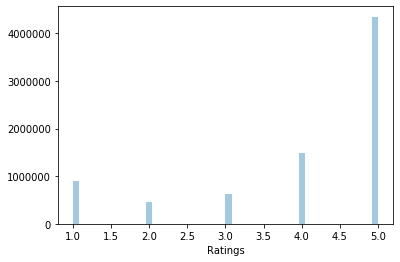

In [11]:
#Plotting Histogram for ratings
sns.distplot(amazon_data['Ratings'], kde=False)

From the data analysis,
1. The dataset has 78,24,482 records and 4 attributes of which Timestamp attribute is not relavant to analysis and hence dropping. Thus there are 78,24,482 records and 3 attributes.
2. The datatype is object for User Id and Product Id and float for ratings.
3. No missing values were found.
4. Minimum value of rating is 1 and maximum is 5.
5. The number of unique user ids is 42,01,696 and the number of unique Product Id is 4,76,002
6. From the histogram, it is evident that the most number of rating received is 5 (more than 40,00,000). The next highest number of rating is 4 which is less than 20,00,000. The lease number of rating is for 2.

In [12]:
#Taking a subset of the dataset to make it less sparse/ denser
#Keeping the users only who has given 50 or more number of ratings 
# Top 10 users based on rating
most_rated = amazon_data.groupby('UserId').size().sort_values(ascending=False)[:10]
most_rated

UserId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

In [13]:
counts = amazon_data['UserId'].value_counts()
amazon_data_1 = amazon_data[amazon_data['UserId'].isin(counts[counts >= 50].index)]

In [14]:
print('Number of users who have rated 50 or more items =', len(amazon_data_1))
print('Number of unique Users in final data = ', amazon_data_1['UserId'].nunique())
print('Number of unique Products in final data = ', amazon_data_1['ProductId'].nunique())

Number of users who have rated 50 or more items = 125871
Number of unique Users in final data =  1540
Number of unique Products in final data =  48190


In [15]:
amazon_data_1.shape

(125871, 3)

In [16]:
amazon_data_1.head()

,UserId,ProductId,Ratings
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


Taking a subset of data:
1. Here we are considering the users who have given 50 or more number of ratings.
2. Thus we have a dataset of 1,25,871 records and 3 attributes.
3. The unique number of users is 1540 and unique number of products is 48190.
4. Thus, here we have created a subset of the dataset as the huge numbers causes memory issues and computation becomes difficult

# Popularity based recommender system

In [17]:
#Count of user_id for each unique product as recommendation score 
amazon_data_2 = amazon_data_1.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
amazon_data_2.rename(columns = {'UserId': 'score'},inplace=True)
amazon_data_2.head()

,ProductId,score
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6


In [18]:
#Sort the products on recommendation score 
amazon_data_3 = amazon_data_2.sort_values(['score', 'ProductId'], ascending = [0,1])

In [19]:
#Generate a recommendation rank based upon score 
amazon_data_3['Rank'] = amazon_data_3['score'].rank(ascending=0, method='first')

In [20]:
#Get the top 5 recommendations 
popularity_recommendations = amazon_data_3.head(5) 
popularity_recommendations

,ProductId,score,Rank
39003,B0088CJT4U,206,1.0
24827,B003ES5ZUU,184,2.0
11078,B000N99BBC,167,3.0
38250,B007WTAJTO,164,4.0
38615,B00829TIEK,149,5.0


In [21]:
# Use popularity based recommender model to make predictions
def recommend(User_Id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['UserId'] = User_Id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [22]:
find_recom = [15,121,53]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

Here is the recommendation for the userId: 15

       UserId   ProductId  score  Rank
39003      15  B0088CJT4U    206   1.0
24827      15  B003ES5ZUU    184   2.0
11078      15  B000N99BBC    167   3.0
38250      15  B007WTAJTO    164   4.0
38615      15  B00829TIEK    149   5.0


Here is the recommendation for the userId: 121

       UserId   ProductId  score  Rank
39003     121  B0088CJT4U    206   1.0
24827     121  B003ES5ZUU    184   2.0
11078     121  B000N99BBC    167   3.0
38250     121  B007WTAJTO    164   4.0
38615     121  B00829TIEK    149   5.0


Here is the recommendation for the userId: 53

       UserId   ProductId  score  Rank
39003      53  B0088CJT4U    206   1.0
24827      53  B003ES5ZUU    184   2.0
11078      53  B000N99BBC    167   3.0
38250      53  B007WTAJTO    164   4.0
38615      53  B00829TIEK    149   5.0




C:\Users\mpani\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mpani\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mpani\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

Popularity based recommender system:
1. Using Popularity based recommender system, we have got top 5 recommendations.
2. The top 5 recommendations remain the same irrespective of the User Id as it is computed based on the product that have received most number of ratings.

# User based Collaborative filtering

In [23]:
#Train test split
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(amazon_data_1,reader)
trainset, testset = train_test_split(data, test_size=.30)

# KNN with Means

In [24]:
#Fitting model
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [25]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [26]:
test_pred

[Prediction(uid='A2LCE1D0TW2XY0', iid='B00G1PQVPQ', r_ui=4.0, est=4.1688311688311686, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3LWC833HQIG7J', iid='B00109Y2DQ', r_ui=5.0, est=4.424806132394949, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A27QXQQOLAMRRR', iid='B00G6CLN3Y', r_ui=3.0, est=3.5287878787878793, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A34C9AFFZOI45T', iid='B000HJBESG', r_ui=5.0, est=4.259950742829904, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AOJA1LC8PN7K1', iid='B002RWJHBM', r_ui=5.0, est=4.6391678622668575, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A2XRMQA6PJ5ZJ8', iid='B002C74GPO', r_ui=5.0, est=4.612359550561798, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3MFORLOKIOEQY', iid='B008ZB54P2', r_ui=5.0, est=4.555555555555555, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A233

In [27]:
# get RMSE
accuracy.rmse(test_pred, verbose=True)

RMSE: 1.0476


1.047584364833805

In [28]:
# get MAE
accuracy.mae(test_pred, verbose=True)

MAE:  0.7717


0.7717481048364444

# SVD

In [29]:
algo1 = SVD()
algo1.fit(trainset)

In [30]:
test_pred1 = algo1.test(testset)

In [31]:
accuracy.rmse(test_pred1, verbose=True)

RMSE: 0.9790


0.978951907144477

In [32]:
accuracy.mae(test_pred1, verbose=True)

MAE:  0.7245


0.7244869275193845

In [33]:
# Top 5 recommendation for users:
def get_top_n(test_pred, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, r_ui, est, _ in test_pred:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [34]:
top_n = get_top_n(test_pred, n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A2LCE1D0TW2XY0 ['B00DMS0GTC', 'B00BW6LW7G', 'B003VS9UP4', 'B00A2BVAN8', 'B005BO7FE4']
A3LWC833HQIG7J ['B000089GN3', 'B00123Q8YQ', 'B003ES5ZUU', 'B001N85NMI', 'B003DZ165W']
A27QXQQOLAMRRR ['B003L1ZYZ6', 'B001TUYTZM', 'B000N99BBC', 'B004N6259G', 'B0079TOET8']
A34C9AFFZOI45T ['B002OFL1J8', 'B000HPV3RW', 'B001TH7GUU', 'B004S4R5CK', 'B00B588HY2']
AOJA1LC8PN7K1 ['B002RWJHBM', 'B002KKFP9Y', 'B000IMYIA8', 'B000ZPJ79A', 'B000I1YTTY']
A2XRMQA6PJ5ZJ8 ['B00175VDY4', 'B005UA3I72', 'B004QK5N5W', 'B000HGIWN4', 'B0002OZXHO']
A3MFORLOKIOEQY ['B003ICXCCK', 'B00CKAOJA0', 'B000VX6XL6', 'B00HVT27B8', 'B00G6IJ5NI']
A233TZONT1OGR0 ['B0000TU7IQ', 'B0036VO7WM', 'B00DVQFECE', 'B003UT5GP2', 'B00B1V2FA0']
A2FSOHSM9X13JT ['B000HJPK2C', 'B003M349VS', 'B004I43F9C', 'B0018ZDGAC', 'B001415FIG']
A2Q204DY2L7YRP ['B002V88HFE', 'B004BFZHO4', 'B003ES5ZSW', 'B0056MPWZU', 'B003VTZ070']
A226VGZWOEBPGL ['B0041OSQ9I', 'B004NY9V0O', 'B00JEVHZHC', 'B008I21EA2', 'B00EVIBN8U']
A386LG0LRWKJZP ['B000OEX4UK', 'B004A88RM6', 'B0041F2KIU

In [35]:
#Computing precision and recall for each user
def precision_recall_at_k(test_pred, k=5, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, r_ui, est, _ in test_pred:
        user_est_true[uid].append((est, r_ui))
        
    precisions = dict()
    recalls = dict()
    
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((r_ui >= threshold) for (_, r_ui) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((r_ui >= threshold) and (est >= threshold))
                              for (est, r_ui) in user_ratings[:k])
        
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
        
    return precisions, recalls

In [36]:
precisions, recalls = precision_recall_at_k(test_pred, k=5, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values())/len(precisions))
print(sum(rec for rec in recalls.values())/len(recalls))

0.8545779220779162
0.2529335085095879


User based collaborative filtering:
1. User based collaborative filtering model built using surprise library.
2. Tried 2 approaches - KNN with means and SVD.
3. Knn with means gave RMSE of 105.4 and MAE of 77.8 and SVD gave RMSE of 98.1 and MAE of 72.7
4. The KNN model seemed to be a better model wrt the accuracy scores.
5. The top 5 recommendations have been given for each user using the model built with KNN with Means algorithm.
6. The average precision value for users is 85% which means 80% of the recommendations made are relevant to the user.
7. The average recall value for users is 25% which means 25% of the total number of relevant items appear in the top 5 results.

# Inference

The popularity based recommender system makes the same reccomendations to every user based on maximum number of ratings received. Here the choice of the user is not taken into account and hence there is no personalisation.

The collaborative filtering approach makes personalised recommendations to the user based on past preferences.